**2023-11-13**<p>
**This script is for purpose of comparing the precipitation from observation and model simulation**<p>
**This script is to  calculate and paint the trend of the Indian precipitation**

reference:
https://matplotlib.org/stable/gallery/lines_bars_and_markers/csd_demo.html#sphx-glr-gallery-lines-bars-and-markers-csd-demo-py

In [1]:
from matplotlib import projections
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import sys
import cartopy
import geopandas
import rioxarray
from shapely.geometry import mapping

module_path = '/Users/sunweihao/local-code/module'
sys.path.append(module_path)
from module_sun import mask_use_shapefile

<font color=red> 1. Process the data </font>

In [2]:
shp_path = '/Volumes/samssd/data/shape/indian/'
shp_name = 'IND_adm0.shp'

prect_path = '/Volumes/samssd/data/precipitation/GPCC/'
prect_name = 'precip.mon.total.1x1.v2020.nc'

# Mask the data out of the bound
f0       = xr.open_dataset(prect_path + prect_name)
prect_m  = mask_use_shapefile(f0, "lat", "lon", shp_path + shp_name)

#print(prect_m) # 1548, 180, 360, time starts from 1891-01-01
#============== Calculate JJA mean ===================
# 1. Give the range of months
month_0 = 5 ; month_1 = 9 # 6 - 8 month

# 2. Claim the array
prect_avg = np.zeros((129, 180, 360))

# 3. Calculate
for yyyy in range(129):
    prect_avg[yyyy] = np.average(prect_m['precip'].data[(yyyy * 12 + month_0):(yyyy * 12 + month_1)], axis=0)

#print('Done')
# 4. Give the axis information to the output
ncfile  =  xr.Dataset(
{
    "JJAS_precip": (["time", "lat", "lon"], prect_avg),
},
coords={
    "time": (["time"], np.linspace(1891, 1891 + 129, 129)),
    "lat":  (["lat"],  f0['lat'].data),
    "lon":  (["lon"],  f0['lon'].data),
},
)



<font color=red>2. Whole Indian mean and trend</font>

In [3]:
whole_precip  =  np.zeros((116))
for yyyy in range(116):
    whole_precip[yyyy] = np.nanmean(ncfile['JJAS_precip'].data[yyyy])


<font color=red>3. Paint the trend of the whole Indian precipitation</font>

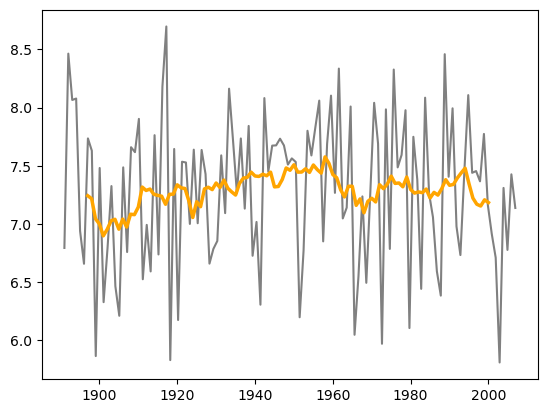

In [4]:
def cal_moving_average(x, w):
        return np.convolve(x, np.ones(w), "valid") / w

w = 13
whole_precip_move = cal_moving_average(whole_precip, w)
#print(whole_precip_move.shape) # 117 points

fig, ax = plt.subplots()
ax.plot(ncfile['time'].data[:116], whole_precip/31, color='grey', linewidth=1.5)
time_process = np.linspace(1891 + (w-1)/2, 2006 - (w-1)/2, 116 - (w-1))
ax.plot(time_process, whole_precip_move/31, color='orange', linewidth=2.5)


plt.savefig("/Volumes/samssd/paint/EUI_GPCC_whole_Indian_rainfall_trend_JJAS_moving13.png", dpi=700)

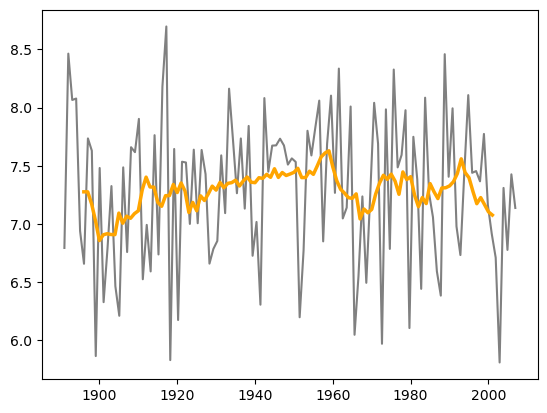

In [5]:
w = 11
whole_precip_move = cal_moving_average(whole_precip, w)
#print(whole_precip_move.shape) # 117 points

fig, ax = plt.subplots()
ax.plot(ncfile['time'].data[:116], whole_precip/31, color='grey', linewidth=1.5)
time_process = np.linspace(1891 + (w-1)/2, 2006 - (w-1)/2, 116 - (w-1))
ax.plot(time_process, whole_precip_move/31, color='orange', linewidth=2.5)

plt.savefig("/Volumes/samssd/paint/EUI_GPCC_whole_Indian_rainfall_trend_JJAS_moving11.png", dpi=700)

## Add the trend to the time series

## <font color=red>1. calculate deviation and linear trend</font>

In [85]:
# Here select 1970 years is the dividing line
import pymannkendall as mk

whole_precip_factual     = whole_precip[60:].copy()
whole_precip_prefactual  = whole_precip[9:66].copy()

whole_precip_factual     -= np.average(whole_precip)
#print(whole_precip_factual)
whole_precip_factual     /= 31
whole_precip_prefactual  -= np.average(whole_precip)
whole_precip_prefactual  /= 31

test1  =  mk.original_test(whole_precip_prefactual, alpha=0.05)
test2  =  mk.original_test(whole_precip_factual,    alpha=0.05)

#test1
#test2
#time1  =  ncfile['time'].data[:75]
#time2  =  ncfile['time'].data[75:-13]

#z1     =  np.polyfit(time1, whole_precip_prefactual, 1)
#p1     =  np.poly1d(z1)
#z2     =  np.polyfit(time2, whole_precip_factual, 1)
#p2     =  np.poly1d(z2)

test1

Mann_Kendall_Test(trend='increasing', h=True, p=0.021887087029410113, z=2.2923216915608298, Tau=0.20927318295739347, s=334.0, var_s=21102.666666666668, slope=0.009350419730355969, intercept=-0.05616124559697194)

## 2. plot picture and add trend

Mann_Kendall_Test(trend='no trend', h=False, p=0.13832148346037698, z=1.4820707020327635, Tau=0.11711711711711711, s=325.0, var_s=47791.666666666664, slope=0.004598011538619768, intercept=0.035524079924063784)

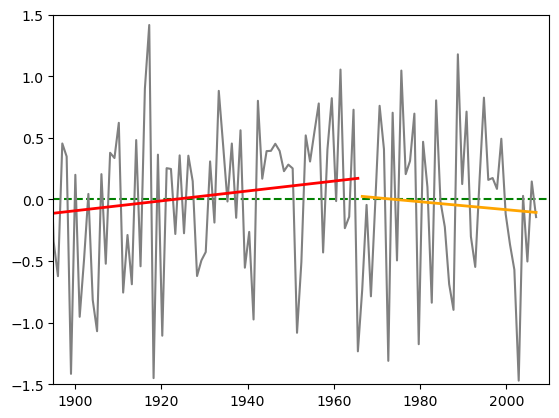

In [30]:
fig, ax = plt.subplots()

ax.set_ylim((-1.5, 1.5))
ax.set_xlim((1895, 2010))

ax.plot([1895, 2010], [0, 0], 'g--')
ax.plot(ncfile['time'].data[:-13], whole_precip/31 - np.average(whole_precip/31), color='grey', linewidth=1.5)

#ax.plot(time2, whole_precip_prefactual, color='grey', linewidth=1.5)

ax.plot(time1, p1(time1), color='red', linewidth=2)
ax.plot(time2, p2(time2), color='orange', linewidth=2)

#print(whole_precip_prefactual)
test1
#plt.savefig("/Volumes/samssd/paint/EUI_GPCC_whole_Indian_rainfall_trend_JJAS_moving11.png", dpi=700)

### 